### 필요한 모듈을 가져오고 데이터를 로드합니다

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'DejaVu Sans'

In [2]:
# FinanceDataReader로 데이터를 불러옵니다
# 예측할 종목은 한양증권(001750) 입니다

import FinanceDataReader as fdr
STOCK_CODE = '001750'

In [3]:
# 기간은 1년으로 잡았습니다

df = fdr.DataReader(STOCK_CODE, '2010-12-31', '2020-12-31')

df.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2011-01-03,9650,9700,9620,9650,17148,0.005208
2011-01-04,9680,9730,9680,9700,22315,0.005181
2011-01-05,9700,9750,9620,9630,17870,-0.007216
2011-01-06,9630,9690,9570,9580,37280,-0.005192
2011-01-07,9580,9650,9540,9610,75268,0.003132


In [4]:
# df.loc[:, "close"]를 하면 모든 row의 close를 인덱싱합니다
# 수익계산을 위해 조정된 종가만 유지하였습니다

df = df.loc[:, ['Close']]

# pandas DataFrame의 칼럼의 이름이 바뀐다

df.rename(columns={'Close':'adj_close'}, inplace=True)

In [5]:
# 단순 수익률을 계산하기 위해 현재 요소와 이전 요소 사이의 백분율 변화를 계산하는 pct_change 를 사용합니다.

df['simple_rtn'] = df.adj_close.pct_change()

# np.log를 사용하여 자연 로그를 취했습니다

df['log_rtn'] = np.log(df.adj_close/df.adj_close.shift(1))

## 한양증권의 주가 내역 및 수익이 포함된 DataFrame을 준비합니다

In [6]:
# 결과 DataFrame은 다음과 같습니다. 
# 수익을 계산하는데 사용할 이전 가격이 없기 때문에 
# 첫 번째 행에는 항상 숫자가 아님(NaN)값이 포함됩니다

df

,adj_close,simple_rtn,log_rtn
Date,,,
2011-01-03,9650,NaN,NaN
2011-01-04,9700,0.005181,0.005168
2011-01-05,9630,-0.007216,-0.007243
2011-01-06,9580,-0.005192,-0.005206
2011-01-07,9610,0.003132,0.003127
...,...,...,...
2020-12-23,9450,0.007463,0.007435
2020-12-24,9530,0.008466,0.008430
2020-12-28,9530,0.000000,0.000000


In [7]:
# 롤링 평균과 표준 편차를 계산합니다

df_rolling = df[['simple_rtn']].rolling(window=21).agg(['mean', 'std'])
df_rolling.columns = df_rolling.columns.droplevel()

In [8]:
# 롤링 메트릭을 원래 데이터에 결합합니다

df_outliers = df.join(df_rolling)

In [9]:
# 이상 값을 감지하는 함수를 정의합니다

def indentify_outliers(row, n_sigmas=3):
    x = row['simple_rtn']
    mu = row['mean']
    sigma = row['std']
    
    if (x > mu + 3 * sigma) | (x < mu - 3 * sigma):
        return 1
    else:
        return 0

In [10]:
# 이상 값을 식별하고 나중에 사용할 수 있도록 값을 추출합니다.

df_outliers['outlier'] = df_outliers.apply(indentify_outliers,     
                                           axis=1)                                                                                                       
outliers = df_outliers.loc[df_outliers['outlier'] == 1,   
                           ['simple_rtn']]   

In [11]:
outliers

,simple_rtn
Date,
2011-03-15,-0.034254
2011-03-30,-0.056583
2011-08-09,-0.080933
2012-03-29,-0.080933
2012-09-14,0.051887
2012-11-23,-0.034639
2013-04-08,-0.023697
2013-12-05,0.027244
2014-04-10,0.035115


## 시각화하기
> 데이터 작업을 하는 동안 평소와는 다른 이상치가 발생하는 경우가 있습니다. 금융시장에서 중요한 일 등의 이유 때문입니다. 기계학습 알고리즘과 통계적인 작업들이 이상치의 영향을 받아 부정확하거나 편향된 결과를 초래할 수 있습니다. 그렇기 때문에 모델을 생성하기 전에 이상값을 처리해야 합니다

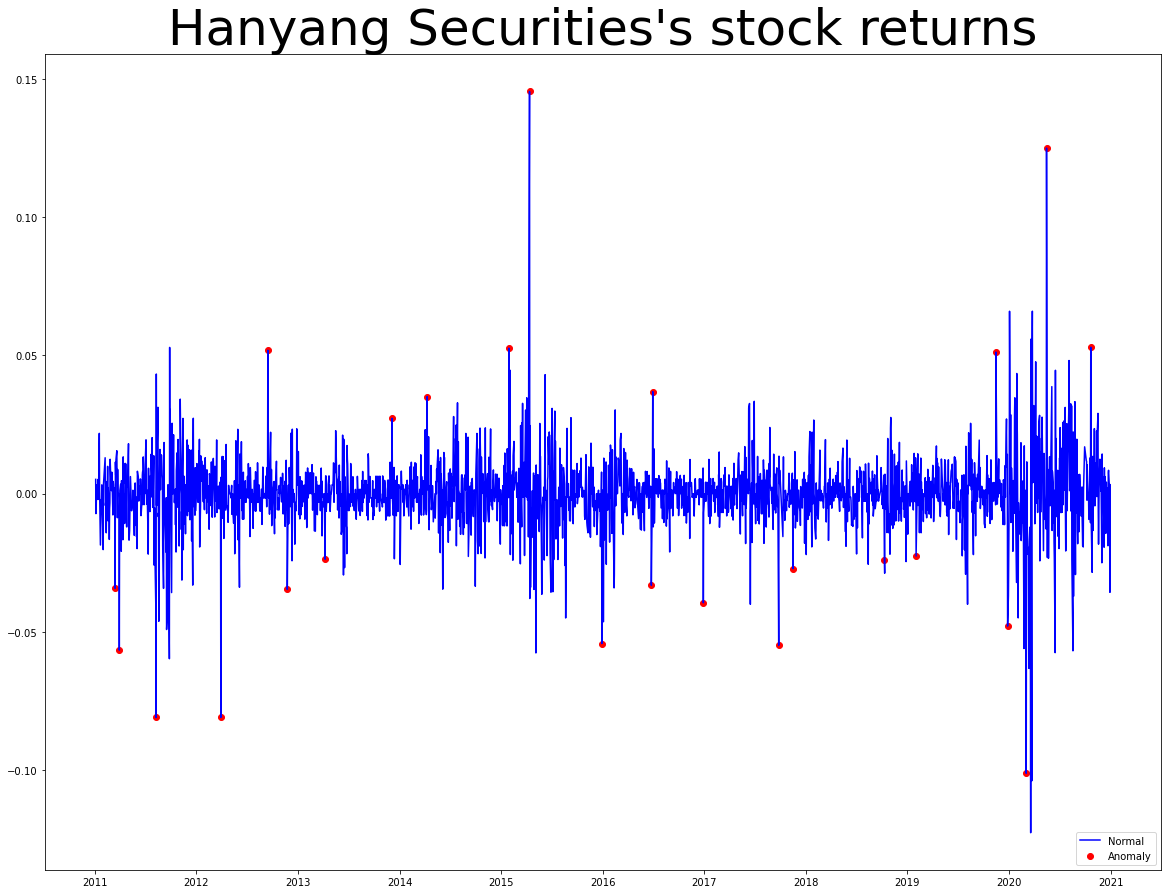

In [12]:
fig, ax = plt.subplots(figsize=(20,15))

ax.plot(df_outliers.index, df_outliers.simple_rtn, 
        color='blue', label='Normal')
ax.scatter(outliers.index, outliers.simple_rtn, 
           color='red', label='Anomaly', )
ax.set_title("Hanyang Securities's stock returns", fontsize=50)
ax.legend(loc='lower right')